## Packages loaded

In [579]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

from hidden_markov import hmm

## Get morse and ascii dictionaries

In [580]:
alphabet = list('abcdefghijklmnopqrstuvwxyz-')
values = ['.-', '-...', '-.-.', '-..', '.', '..-.', '--.', '....', '..', '.---', '-.-', 
          '.-..', '--', '-.','---', '.--.', '--.-', 
          '.-.', '...', '-', '..-', '...-', '.--', '-..-', '-.--', '--..','-....-']

morse_dict = dict(zip(alphabet, values))
ascii_dict = dict(map(reversed, morse_dict.items()))

In [581]:
print(morse_dict)

{'a': '.-', 'b': '-...', 'c': '-.-.', 'd': '-..', 'e': '.', 'f': '..-.', 'g': '--.', 'h': '....', 'i': '..', 'j': '.---', 'k': '-.-', 'l': '.-..', 'm': '--', 'n': '-.', 'o': '---', 'p': '.--.', 'q': '--.-', 'r': '.-.', 's': '...', 't': '-', 'u': '..-', 'v': '...-', 'w': '.--', 'x': '-..-', 'y': '-.--', 'z': '--..', '-': '-....-'}


In [582]:
print(ascii_dict)

{'.-': 'a', '-...': 'b', '-.-.': 'c', '-..': 'd', '.': 'e', '..-.': 'f', '--.': 'g', '....': 'h', '..': 'i', '.---': 'j', '-.-': 'k', '.-..': 'l', '--': 'm', '-.': 'n', '---': 'o', '.--.': 'p', '--.-': 'q', '.-.': 'r', '...': 's', '-': 't', '..-': 'u', '...-': 'v', '.--': 'w', '-..-': 'x', '-.--': 'y', '--..': 'z', '-....-': '-'}


## Functions to convert text to morse code and vice versa

In [583]:
def morse_encode(text):
    return ' '.join([''.join(morse_dict.get(i, '')) for i in text.lower()])
 
# convert morse code to text
def morse_decode(code):
    return ''.join([ascii_dict.get(i, '') for i in code.split(' ')])

In [584]:
text = "hallo welt"

In [585]:
morse_encode(text)

'.... .- .-.. .-.. ---  .-- . .-.. -'

In [586]:
code ='.... .- .-.. .-.. ---  .-- . .-.. -'

In [587]:
morse_decode(code)

'hallowelt'

## Read file and plot the spectogramm

In [588]:
fs, data = wavfile.read('C:/home/stefan/PRA/morse.wav')

# spectral representation
f, t, S = signal.spectrogram(data, fs)

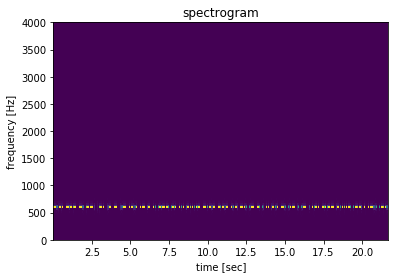

In [589]:
plt.figure(0) # spectrogram
plt.pcolormesh(t, f, S)
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')
plt.title('spectrogram')
plt.show()

## Convert to binary sequence and plot 

In [590]:
def choose_freq_c(S, threshold=0.975):
    '''Return the indexes of S that meet the threshold.
    Threshold will be used to select the quantiles
    '''
    indices = []
    sums = []
    for i, intensity in enumerate(S):
        sums.append(sum(intensity))
    limiter = np.quantile(sums, threshold)
    for i, intensity_sum in enumerate(sums):
        if intensity_sum >= limiter:
            indices.append(i)
    return indices

def transform_binary(S, threshold=0.5):
    '''Return binary representation
    '''
    steps = np.mean(S, axis=0)
    #steps = S[np.argmax(np.sum(S, axis=1)),:]
    return list(map(lambda x: 1 if x >= np.quantile(steps, threshold) else 0, steps))

In [591]:
f_index = choose_freq_c(S)
binary_data = transform_binary(S[f_index,:])

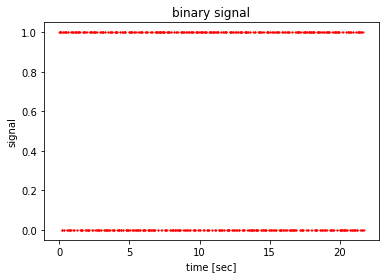

In [592]:
plt.figure(1)    # binary sequence
plt.plot(t,binary_data,'ro', markersize=1)
plt.ylabel('signal')
plt.xlabel('time [sec]')
plt.title('binary signal')
plt.show()


## Initialize the Hidden Markov Model

In [593]:
states = ('.1','.2','-1','-2','-3','-4','-5','-6',' 1',' 2','_1','_2','_3','_4','_5','_6','x')
symbols = (True,False)

# morse symbols correspondig to states
state_values = ['.','','-','','','','','','','',' ','','','','','','']
state_dict = dict(zip(states, state_values))

# convert state sequence to morse symbols, remove trailing or leading spaces
def state_decode(sequence):
    return (''.join([''.join(state_dict[i]) for i in sequence])).strip()
 
#==============================================================================
# set up and run hidden markov model
    
# we assume that we do not start in the middle of a symbol
initial = np.matrix([
        [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
    ])

##__TODO__ define transition matrix
# state  .1 .2 -1 -2 -3 -4 -5 -6  1  2 _1 _2 _3 _4 _5 _6 x    
transition = np.matrix([
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # .1 
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], # .2 nominal length
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -1
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -2
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -3
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -4
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # -5  
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], # -6 nominal length
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], #  1
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], #  2 nominal length
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], # _1
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], # _2
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], # _3
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], # _4
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], # _5
            [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # _6 nominal length
            [1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]  # x  indifferent     
        ])
# emission probabilities
emission = np.matrix([
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1], # emitting 'True'
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]  # emitting 'False'
    ]).transpose() 
  
    
# scale as probabilities, e.g. that components sum up to 1
initial = initial / np.sum(initial, axis=1).reshape((-1, 1))
transition = transition / np.sum(transition, axis=1).reshape((-1, 1))
emission = emission / np.sum(emission, axis=1).reshape((-1, 1))


The transition matrix was found by tiral and error

## Develop model and print result

In [594]:
model = hmm(states, symbols, initial, transition, emission)

# run viterbi decoder
state_sequence = model.viterbi(binary_data)

result = morse_decode(state_decode(state_sequence))

print('Decoded string =>',result,'<=')

Decoded string => congratulations-you-did-very-well <=


## Repeat the same steps with noisy audio 

In [608]:
fsx, datax = wavfile.read('C:/home/stefan/PRA/morse_noise_0,000001.wav')

# spectral representation
fx, tx, Sx = signal.spectrogram(datax, fsx)

In [596]:
f_indexx = choose_freq_c(Sx)
binary_datax = transform_binary(Sx[f_indexx,:])

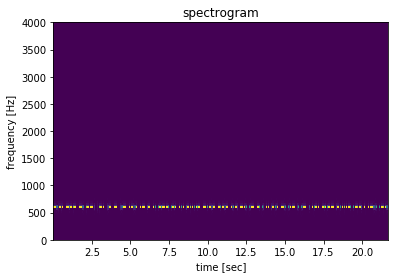

In [597]:
plt.figure(2) # spectrogram
plt.pcolormesh(tx, fx, Sx)
plt.ylabel('frequency [Hz]')
plt.xlabel('time [sec]')
plt.title('spectrogram')
plt.show()

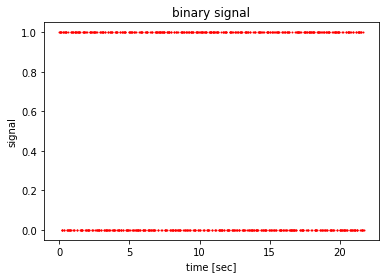

In [598]:
plt.figure(3)    # binary sequence
plt.plot(t,binary_datax,'ro', markersize=1)
plt.ylabel('signal')
plt.xlabel('time [sec]')
plt.title('binary signal')
plt.show()

In [599]:
modelx = hmm(states, symbols, initial, transition, emission)

# run viterbi decoder
state_sequencex = model.viterbi(binary_datax)

result = morse_decode(state_decode(state_sequencex))

print('Decoded string =>',result,'<=')

Decoded string => kongratulttions-yoadid-vry-werr <=


Even with the smallest possible amplitude of the white noise(0,000001), one could choose, except zero) in audacity, the algorithm degrades that much that the morse code can not be translated into characters.


## Baum-Welch algorithm

Even though I attempted to use the Baum-Welch algorithm it somehow did not work. After trying to fit the given data into the algorithm, the same error occured: ValueError: operands could not be broadcast together with shapes (17,2) (1,17) 
A Google Search resultet in changing the line 349 of hmm_class.py to emProbNew = emProbNew/ np.reshape(em_norm.transpose(),[-1,1]), which does not seem like a good solution. Maybe it needs further investigation.

In [600]:
unique, counts = np.unique(binary_datax, return_counts=True)

In [601]:
count = list(zip(unique, counts))

In [602]:
print(count)

[(0, 387), (1, 388)]


In [603]:
lower_50 = tuple(binary_datax[:387])
upper_50 = tuple(binary_datax[388:])

obs = []
obs.extend([lower_50, upper_50])

In [604]:
count = [387,388]
num_iter = 100

In [607]:
modelx.train_hmm(obs, num_iter, count)


ValueError: operands could not be broadcast together with shapes (17,2) (1,17) 